<a href="https://colab.research.google.com/github/inlytica-Library/Dataset_Simple_Linear_Regression/blob/main/sales_funnel_valuation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skewnorm
from matplotlib.ticker import PercentFormatter
from matplotlib.patches import Patch


Inputs:

In [ ]:
# Simulation parameters
N   = 100_000
rng = np.random.default_rng(42)  # This is the recommended random number generator since NumPy 1.17

In [ ]:
# Simulate funnel deals / stage and funnel stages

rng_deals = np.random.default_rng(7)

# Funnel Stages
stage_probabilities  = np.array([0.10, 0.35, 0.60, 0.90], float)
stage_counts = np.array([50,   30,   15,   5  ], int)  # totals 100

medians_by_stage = np.array([300_000, 300_000, 300_000, 300_000], float)

sigma_by_stage   = np.array([0.8, 0.6, 0.5, 0.4], float)

# Generate per-stage deal values (lognormal with given medians/sigmas)
deal_values_by_stage = []
for median, sigma, n in zip(medians_by_stage, sigma_by_stage, stage_counts):
    mu = np.log(median)            # lognormal median = exp(mu)
    vals = rng.lognormal(mean=mu, sigma=sigma, size=n)
    vals = np.round(vals / 1000) * 1000  # round to nearest $1k (optional)
    deal_values_by_stage.append(vals.astype(float))

deal_values = np.concatenate(deal_values_by_stage)            # shape (100,)
stage_probabilities_expanded = np.repeat(stage_probabilities, stage_counts) # shape (100,)

In this case, the management team estimated their funnel value to be in the $ 10.0 - $ 10.5 million range.

In [ ]:

acquisition_guidance = (deal_values * stage_probabilities_expanded).sum()
acquisition_guidance_band = (round(acquisition_guidance-500_000,-6), round(acquisition_guidance + 500_000,-6))  # Where the acquistion target executives believe the funnel amount will land.



Tuning Parameters

In [ ]:
# Stage Parameters

probability_uncertainity = .6 #Tune 0-1

# Deal Parameters
deal_size_starting_volatility = .45
deal_size_tightening_factor = .35
deal_size_tightening_min_volatility = 0.15
deal_size_tightening_max_volatility = 0.4

deal_size_skew = -8.0
deal_size_taper = 1.2




To solve the dual problems of uncertainity in the actual probabilities of closing and the fact that a 20% close (for example) means that 1 out of 5 deals will close rather than "we will receive 20% of the dollars", we sample from a beta distribution for N runs for each probability to get a probability of closing give our uncertainity. This uncertainity of the probability of closing is influenced by a concentration factor that goes up as the probability gets higher. This is because as the deal stage progresses, we assume that more is known about the deal and the forecast is more accurate. Then, using each probability of closing as the probability in a binomial distribution, we do a coin flip to determine whether or not the deal closes. This would be a 0 or a 1.

In [ ]:

def log_interp(a, b, t):
    # Geometric interpolation from a -> b as t goes 0->1
    return a * (b / a) ** t

def concentration_factor_for_probability_of_closing(p, noise_dial,
                                                   tight=10_000.0, loose=1.2,
                                                   min_mult=1.0, max_mult=4.0,
                                                   curve=2.0):
    """
    Returns a vector of kappas (same shape as p).
      - noise_dial controls global tightness (0 tight .. 1 loose)
      - stage multiplier increases with p**curve so later stages are tighter
    """
    # global dial
    k_global = log_interp(tight, loose, noise_dial)

    # stage multiplier grows with p (later stages => higher concentration)
    stage_mult = min_mult + (max_mult - min_mult) * (p ** curve)

    # final per-stage kappa
    kappa = k_global * stage_mult
    return kappa

# Vector of per-stage concentrations (shape matches stage_probabilities)
stage_concentration = concentration_factor_for_probability_of_closing(
    stage_probabilities, probability_uncertainity
)

# Optional: quick sanity check
# print("kappa by stage:", stage_concentration)

alpha_probabilities = stage_probabilities * stage_concentration
beta_probabilities  = (1.0 - stage_probabilities) * stage_concentration

win_probabilities_stage = rng.beta(alpha_probabilities, beta_probabilities,
                                   size=(N, stage_probabilities.size))  # (N, 4)
win_probabilities = np.repeat(win_probabilities_stage, stage_counts, axis=1)
win_binomial = rng.binomial(1, win_probabilities)




Now we will create a matrix of deal size multipliers given our uncertainity driven (as above) by funnel stage. These will modify the size of the deals. To do this, we will use the Azzalini trick to create a "log skewnormal" distribution. We want to use log space so that all our values are positive and we want to skew it left because, in my experience, optimism abounds when dealing with sales teams. Also, as above, we want the uncertainity to diminish as the sales stages progress.

We will use two parameters in our distribution: alpha and omega.

Alpha (alpha_deal_size) will be a skew factor. We will use it to tilt the skew-normal in log-space. After exponentiation, it sets the asymmetry of the skew-lognormal multipliers. Negative values of alpha make the downside tail heavier (deals are more likely to come in below forecast), while values closer to zero reduce the skew and make the distribution more symmetric. As the funnel stages progess, alpha approaches zero and the bias toward the downside diminishes.

Omega (omega_deal_size) will be a "spread factor". Omega scales the standard deviation of the skew-normal in log-space. After exponentiation, it controls the spread of the skew-lognormal multipliers. As the funnel stages progess, omega shrinks and the uncertainity around the deal-size decreases.





In [ ]:
def omega_deal_size(stage_probs):
  return np.clip(deal_size_starting_volatility - deal_size_tightening_factor*stage_probs, deal_size_tightening_min_volatility, deal_size_tightening_max_volatility)      # Scale parameter (like sigma) -> linear equation that gets smaller as stage gets higher. Remains between .15 and .4.

def alpha__deal_size(stage_probs):
    return deal_size_skew*(1 - stage_probs)**deal_size_taper       # skew paramter -> convex; tweak strength/exponent -8.0
   # return np.clip(a, -10.0, -0.2)


omega_per_deal = omega_deal_size(stage_probabilities_expanded)

alpha_per_deal = alpha__deal_size(stage_probabilities_expanded)


def deal_value_multipliers(N, alpha, omega, rng):

    # Number of deals (columns)
    D = alpha.size


    #    Use SciPy to create a skewnorm distribution
      #    - a=alpha[None, :] broadcasts the per-deal shape across N rows
      #    - loc=0, scale=1 keeps it "standard" before our log scaling
      #    - size=(N, D) returns a full matrix of draws
      #    - random_state=rng ties SciPy to your NumPy Generator

    skewnormal_draw = skewnorm.rvs(a=alpha[None, :], loc=0.0, scale=1.0,
                     size=(N, D), random_state=rng)

    # 2) Apply per-deal log scale (omega) -> this sets the spread in log space
    # We treat skewnormal_draw_scaled as the log (remember this can and will likely be negative)
    skewnormal_draw_scaled = omega[None, :] * skewnormal_draw # shape (N, D)

    # 3) Exponentiate to move to positive support (log–skew-normal multipliers)
    # When we convert the scaled sample from the skewnormal pdf, we turn it into a percentage factor for example if skewnormal_draw_scaled = -0.3, then the multiplier would be approx. .74
    multiplier = np.exp(skewnormal_draw_scaled)       # shape (N, D)

    # 4) Median-normalize each column so the typical multiplier is ~1.0
    # We are not going to use this since we want a bias in our results.
    #    (prevents systematic drift in deal values just from adding noise)
    # multiplier_raw_median = np.median(multiplier_raw, axis=0)           # shape (D,)
    # multiplier = multiplier_raw / multiplier_raw_median[None, :]                 # shape (N, D)

    return multiplier

In [ ]:
deal_value_multipliers_output = deal_value_multipliers(N, alpha_per_deal, omega_per_deal, rng)

# Add a shared (stage-level) size factor per simulation so size uncertainty doesn't average out across many deals

# tau_stage = 0.15  # try 0.05 (tight), 0.15 (moderate), 0.25 (looser)

# stage_size_factor = rng.lognormal(mean=0.0, sigma=tau_stage, size=(N, stage_probs.size))   # (N,4)
# stage_size_factor_per_deal = np.repeat(stage_size_factor, stage_counts, axis=1)            # (N,100)

deal_values_with_uncertainity = deal_value_multipliers_output * deal_values


In [ ]:
funnel_estimates = (win_binomial * deal_values_with_uncertainity).sum(axis=1)

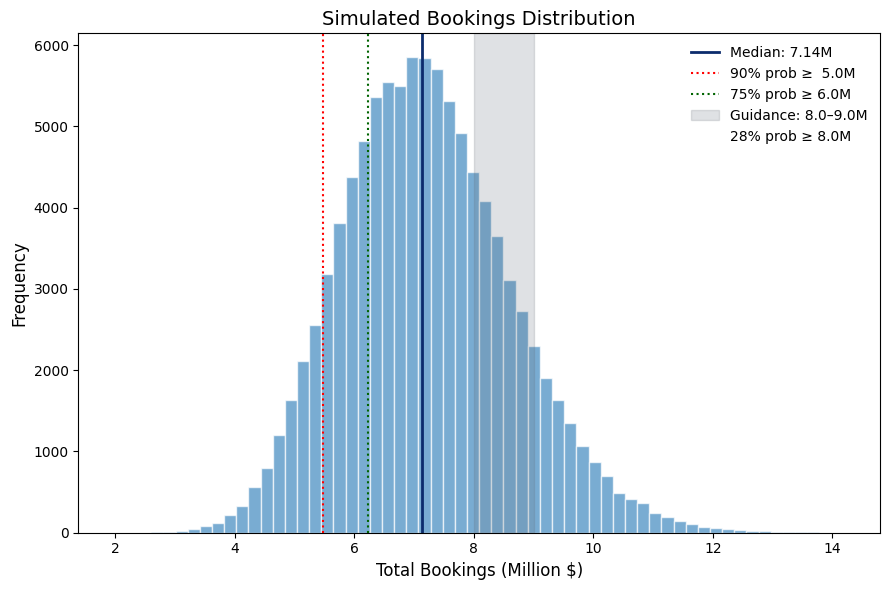

Median: $7,137,087 | 90% CI: $5,037,926–$9,695,568
P(hit 8,000,000–9,000,000) = 16.6%
P(bookings ≥ 8,000,000) = 27.5%
≥ @90% (p10): $5,000,000
≥ @75% (p25): $6,000,000


In [ ]:
p05, p50, p95 = np.percentile(funnel_estimates, [5, 50, 95])

p10, p25 = np.percentile(funnel_estimates, [10, 25])

def round_to_millions(x): return round(x, -6)

p10_r, p25_r = round_to_millions(p10), round_to_millions(p25)


prob_guidance = ((funnel_estimates >= acquisition_guidance_band[0]) & (funnel_estimates <= acquisition_guidance_band[1])).mean()

low, high = acquisition_guidance_band  # e.g., (8_000_000, 10_000_000)

# Probability of hitting AT LEAST the low end of guidance
p_at_least_low = (funnel_estimates >= low).mean()


# --- Plot settings ---
hist_color   = "#4089bf"   # change to taste, e.g. "tomato", "#33a988"  #199ae6
line_color   = "#0c2c6c"
band_color   = "#636D78"

plt.figure(figsize=(9,6))

# Histogram
plt.hist(funnel_estimates/1e6, bins=60, color=hist_color, alpha=0.7, edgecolor="white")

# Percentile lines
#plt.axvline(p05/1e6, color="red", linestyle="--", linewidth=1.5, label=f"5th: {p05/1e6:.2f}M")
plt.axvline(p50/1e6, color=line_color, linestyle="-",  linewidth=2.0, label=f"Median: {p50/1e6:.2f}M")
#plt.axvline(p95/1e6, color="red", linestyle="--", linewidth=1.5, label=f"95th: {p95/1e6:.2f}M")

plt.axvline(p10/1e6, color="red", linestyle=":", linewidth=1.5,
            label=f"90% prob ≥  {p10_r/1e6:.1f}M ")
plt.axvline(p25/1e6, color="darkgreen", linestyle=":", linewidth=1.5,
            label=f"75% prob ≥ {p25_r/1e6:.1f}M ")


# Guidance band shading
plt.axvspan(acquisition_guidance_band[0]/1e6, acquisition_guidance_band[1]/1e6,
            color=band_color, alpha=0.2,
            label=f"Guidance: {acquisition_guidance_band[0]/1e6:.1f}–{acquisition_guidance_band[1]/1e6:.1f}M")

plt.axvline(low/1e6,  linewidth=2.0, color="white", linestyle="",
            label=f"{p_at_least_low:.0%} prob ≥ {low/1e6:.1f}M ")

# Labels & title
plt.xlabel("Total Bookings (Million $)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Simulated Bookings Distribution", fontsize=14)

# Legend
plt.legend(frameon=False)

# Grid for readability
plt.grid(axis="y", alpha=0.3)

# Save to file (PNG, high resolution for blog)
plt.tight_layout()
plt.savefig("bookings_histogram.png", dpi=300)

# plt.axvline(low/1e6, color="orange", linestyle=":",#funnel_estimates.max()/1e6, alpha=0.12,
#             label=f"P(≥ {low/1e6:.1f}M) = {p_at_least_low:.1%}")
#plt.legend(frameon=False)

# Show inline
plt.grid(False)
plt.show()

print(f"Median: ${p50:,.0f} | 90% CI: ${p05:,.0f}–${p95:,.0f}")
print(f"P(hit {acquisition_guidance_band[0]:,.0f}–{acquisition_guidance_band[1]:,.0f}) = {prob_guidance:.1%}")
print(f"P(bookings ≥ {low:,.0f}) = {p_at_least_low:.1%}")
print(f"≥ @90% (p10): ${p10_r:,.0f}")
print(f"≥ @75% (p25): ${p25_r:,.0f}")


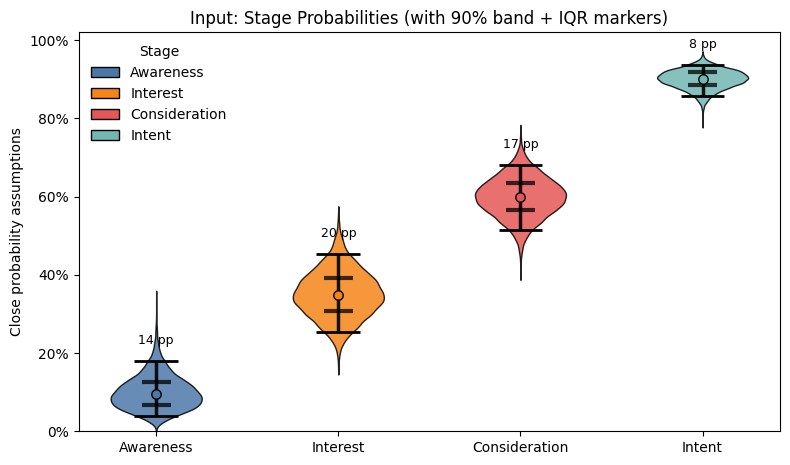

In [ ]:


# --- Labels & indices ---
stage_labels = ["Awareness", "Interest", "Consideration", "Intent"]
stage_idx = np.repeat(np.arange(stage_probabilities.size), stage_counts)  # shape (D,)
stage_colors = ["#4C78A8", "#F58518", "#E45756", "#72B7B2"]  # one per stage

# --- 1) Probability noise by stage (violin plot + noise markers) ---
prob_plot_rows = min(10_000, win_probabilities_stage.shape[0])
prob_rows = rng.choice(win_probabilities_stage.shape[0], prob_plot_rows, replace=False)
prob_samples_by_stage = [win_probabilities_stage[prob_rows, j] for j in range(stage_probabilities.size)]

fig1, ax1 = plt.subplots(figsize=(8, 4.75))
parts = ax1.violinplot(prob_samples_by_stage, showmeans=False, showmedians=False, showextrema=False)

# Color each violin by stage
for body, col in zip(parts['bodies'], stage_colors):
    body.set_facecolor(col)
    body.set_edgecolor("black")
    body.set_alpha(0.85)

# Compute percentiles & draw noise markers
meds = []
for i, (samples, col) in enumerate(zip(prob_samples_by_stage, stage_colors), start=1):
    p5, p25, p50, p75, p95 = np.percentile(samples, [5, 25, 50, 75, 95])
    meds.append(p50)

    # 90% band (p5–p95)
    ax1.vlines(i, p5, p95, colors="black", lw=2.5, alpha=0.9)
    ax1.hlines([p5, p95], i - 0.12, i + 0.12, colors="black", lw=2)

    # IQR caps (p25 & p75)
    ax1.hlines([p25, p75], i - 0.08, i + 0.08, colors="black", lw=3, alpha=0.75)

    # Median dot (colored to match violin)
    ax1.scatter(i, p50, s=46, c=col, edgecolors="black", zorder=3)

    # Label the noise level (width of 90% band) in percentage points
    noise_pp = (p95 - p5) * 100.0
    y_text = min(0.985, p95 + 0.035)  # keep label inside the axis
    ax1.text(i, y_text, f"{noise_pp:.0f} pp", ha="center", va="bottom", fontsize=9)

# Axes formatting
ax1.set_xticks(np.arange(1, len(stage_labels) + 1))
ax1.set_xticklabels(stage_labels)
ax1.yaxis.set_major_formatter(PercentFormatter(xmax=1))
ax1.set_ylim(0, 1.02)
ax1.set_ylabel("Close probability assumptions")
ax1.set_title("Input: Stage Probabilities (with 90% band + IQR markers)")
ax1.grid(True, alpha=0.3)

# Legend for colors
legend_handles = [Patch(facecolor=stage_colors[i], edgecolor="black", label=stage_labels[i])
                  for i in range(len(stage_labels))]
ax1.legend(handles=legend_handles, title="Stage", frameon=False, loc="upper left")

plt.tight_layout()
plt.grid(False)
plt.show()


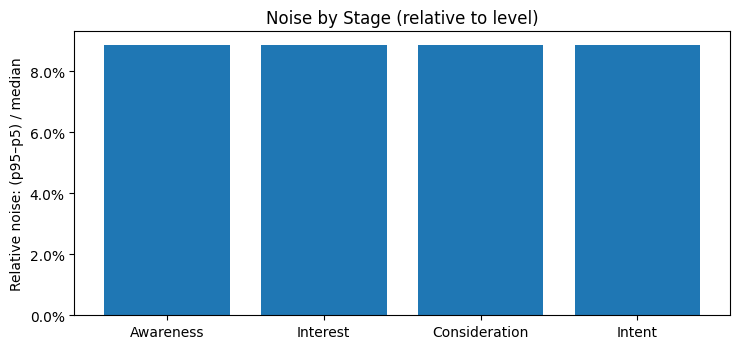

In [ ]:
rel_noise = (p95 - p5) / np.clip(p50, 1e-9, None)

fig, ax = plt.subplots(figsize=(7.5, 3.6))
ax.bar(stage_labels, rel_noise * 100.0)
ax.set_ylabel("Relative noise: (p95–p5) / median")
ax.yaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.set_title("Noise by Stage (relative to level)")
plt.tight_layout()
plt.show()

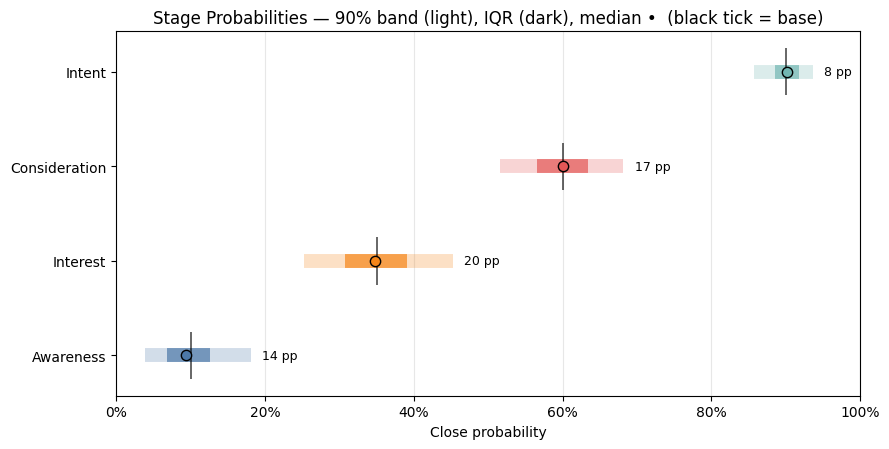

In [ ]:
from matplotlib.ticker import PercentFormatter

# Percentiles across simulations, by stage (axis=0)
p5, p25, p50, p75, p95 = np.percentile(win_probabilities_stage, [5, 25, 50, 75, 95], axis=0)

# Colors per stage (optional)
stage_colors = ["#4C78A8", "#F58518", "#E45756", "#72B7B2"]

# -------- Bullet-style interval chart (absolute noise in percentage points) --------
y = np.arange(len(stage_labels))

fig, ax = plt.subplots(figsize=(9, 4.6))

for i in range(len(stage_labels)):
    # 90% band (p5–p95): light, long bar
    ax.hlines(y[i], p5[i], p95[i], color=stage_colors[i], lw=10, alpha=0.25)
    # IQR (p25–p75): darker, shorter bar on top
    ax.hlines(y[i], p25[i], p75[i], color=stage_colors[i], lw=10, alpha=0.7)
    # Median dot
    ax.scatter(p50[i], y[i], s=55, color=stage_colors[i], edgecolors="black", zorder=3)
    # Optional: show base stage mean as a thin black tick
    ax.vlines(stage_probabilities[i], y[i]-0.25, y[i]+0.25, color="black", lw=1.4, alpha=0.6)
    # Label absolute noise width in percentage points
    ax.text(p95[i] + 0.015, y[i], f"{(p95[i]-p5[i])*100:.0f} pp", va="center", fontsize=9)

ax.set_yticks(y)
ax.set_yticklabels(stage_labels)
ax.set_xlim(0, 1)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=1))
ax.set_xlabel("Close probability")
ax.set_title("Stage Probabilities — 90% band (light), IQR (dark), median •  (black tick = base)")
ax.grid(True, axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


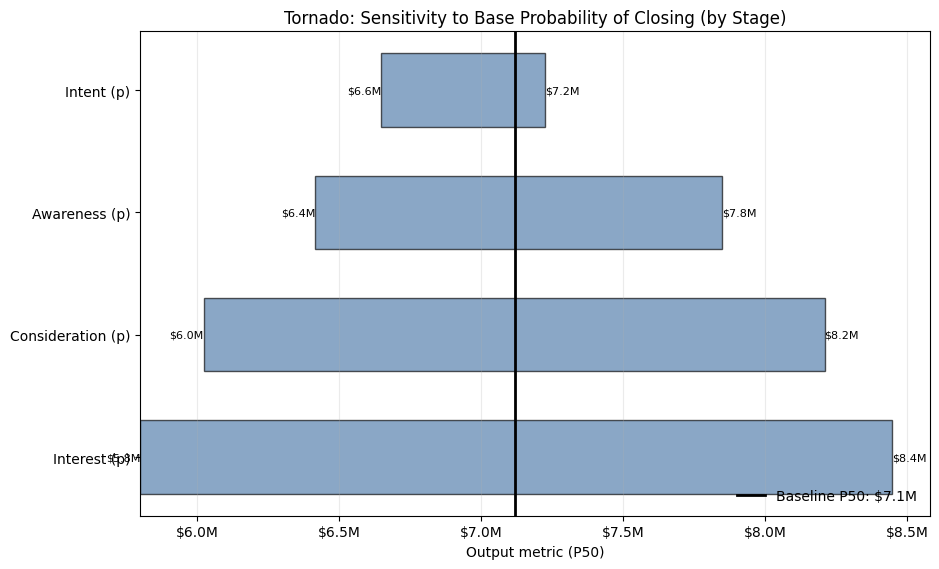

In [ ]:
# ----------------------------
# Tornado: Probability of Closing by Stage (one-way sensitivity)
# ----------------------------
from matplotlib.ticker import FuncFormatter

# Output metric
METRIC = "P50"   # options: "P10", "P50", "P90", "MEAN"

# How much to perturb each stage probability (multiplicative)
LOW_MULT  = 0.50   # 50% of baseline p_j
HIGH_MULT = 1.50   # 150% of baseline p_j

# Optional: stage labels
try:
    stage_labels
except NameError:
    stage_labels = [f"Stage {i+1}" for i in range(stage_probabilities.size)]

# Common random numbers (stable comparisons)
CRN_SEED = 24601

def summarize(totals, metric="P50"):
    if metric == "P10": return np.percentile(totals, 10)
    if metric == "P50": return np.percentile(totals, 50)
    if metric == "P90": return np.percentile(totals, 90)
    return totals.mean()

def simulate_totals_with_stage_probs(stage_probs, seed=CRN_SEED):
    """Re-simulate totals using given base stage probabilities (means).
       Uses your current probability noise dial via concentration_factor_for_probability_of_closing().
    """
    rng_local = np.random.default_rng(seed)

    # --- Close probabilities (respect your noise dial) ---
    kappa = concentration_factor_for_probability_of_closing(stage_probs, probability_uncertainity)  # vector by stage
    a = stage_probs * kappa
    b = (1.0 - stage_probs) * kappa
    win_probs_stage = rng_local.beta(a, b, size=(N, stage_probs.size))       # (N, S)
    win_probs       = np.repeat(win_probs_stage, stage_counts, axis=1)       # (N, D)
    wins            = rng_local.binomial(1, win_probs)

    # --- Deal-size multipliers (keep same as your current model) ---
    omega = omega_deal_size(stage_probabilities_expanded)                    # unchanged by this sensitivity
    alpha_skew = alpha__deal_size(stage_probabilities_expanded)
    mults = deal_value_multipliers(N, alpha_skew, omega, rng_local)          # (N, D)

    totals = (wins * mults * deal_values).sum(axis=1)
    return totals

# Baseline
baseline_totals = simulate_totals_with_stage_probs(stage_probabilities, seed=CRN_SEED)
baseline_metric = summarize(baseline_totals, METRIC)

# One-way sensitivities over stages
factors, ranges = [], []
for j, lbl in enumerate(stage_labels):
    p_lo = stage_probabilities.copy()
    p_hi = stage_probabilities.copy()

    # multiplicative perturbation with clamping to (0,1)
    p_lo[j] = np.clip(p_lo[j] * LOW_MULT, 1e-6, 1 - 1e-6)
    p_hi[j] = np.clip(p_hi[j] * HIGH_MULT, 1e-6, 1 - 1e-6)

    m_lo = summarize(simulate_totals_with_stage_probs(p_lo, seed=CRN_SEED), METRIC)
    m_hi = summarize(simulate_totals_with_stage_probs(p_hi, seed=CRN_SEED), METRIC)

    factors.append(f"{lbl} (p)")
    ranges.append((min(m_lo, m_hi), max(m_lo, m_hi)))

# Sort by effect width (largest on top)
widths = np.array([hi - lo for (lo, hi) in ranges])
order  = np.argsort(widths)[::-1]
factors = [factors[i] for i in order]
ranges  = [ranges[i]  for i in order]

# Plot tornado
y = np.arange(len(factors))
fig, ax = plt.subplots(figsize=(9.5, 5.8))

for i, (lo, hi) in enumerate(ranges):
    ax.barh(y[i], hi - lo, left=lo, height=0.6, color="#4C78A8", alpha=0.65, edgecolor="black")
    ax.text(lo, y[i], f"${lo/1e6:.1f}M", va="center", ha="right", fontsize=8)
    ax.text(hi, y[i], f"${hi/1e6:.1f}M", va="center", ha="left",  fontsize=8)

ax.axvline(baseline_metric, color="black", lw=2, label=f"Baseline {METRIC}: ${baseline_metric/1e6:.1f}M")
ax.set_yticks(y)
ax.set_yticklabels(factors)
ax.xaxis.set_major_formatter(FuncFormatter(lambda v, pos: f"${v/1e6:.1f}M"))
ax.set_xlabel(f"Output metric ({METRIC})")
ax.set_title("Tornado: Sensitivity to Base Probability of Closing (by Stage)")
ax.legend(loc="lower right", frameon=False)
ax.grid(True, axis="x", alpha=0.25)
plt.tight_layout()
plt.show()


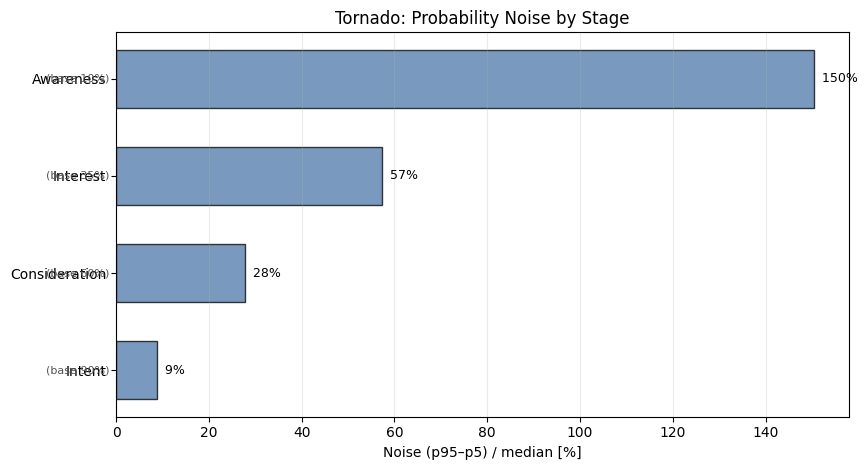

In [ ]:
# ----------------------------
# Tornado: Probability Noise by Stage
# ----------------------------
from matplotlib.ticker import PercentFormatter

# Choose how to measure noise
METRIC = "relative"   # options: "pp", "relative", "logit"
NORMALIZE_LOGIT = True  # if METRIC == "logit", scale to 0–100% (for readability)

def logit(x):
    x = np.clip(x, 1e-9, 1-1e-9)
    return np.log(x/(1-x))

# Percentiles across simulations, by stage
p5, p25, p50, p75, p95 = np.percentile(win_probabilities_stage, [5, 25, 50, 75, 95], axis=0)

# Compute noise per stage
if METRIC == "pp":
    noise_vals = (p95 - p5) * 100.0
    xlabel = "Noise (p95–p5) [percentage points]"
    fmt = lambda v: f"{v:.0f} pp"
elif METRIC == "relative":
    noise_vals = ((p95 - p5) / np.clip(p50, 1e-9, None)) * 100.0
    xlabel = "Noise (p95–p5) / median [%]"
    fmt = lambda v: f"{v:.0f}%"
elif METRIC == "logit":
    L5, L95 = np.percentile(logit(win_probabilities_stage), [5, 95], axis=0)
    noise_vals = L95 - L5  # in log-odds units
    if NORMALIZE_LOGIT:
        noise_vals = (noise_vals / noise_vals.max()) * 100.0
        xlabel = "Relative noise (logit 90% width, normalized)"
        fmt = lambda v: f"{v:.0f}%"
    else:
        xlabel = "Noise (p95–p5) in log-odds (logit units)"
        fmt = lambda v: f"{v:.2f}"
else:
    raise ValueError("METRIC must be 'pp', 'relative', or 'logit'")

# Sort largest to smallest (tornado style)
order = np.argsort(noise_vals)[::-1]
vals_sorted = noise_vals[order]
labels_sorted = [stage_labels[i] for i in order]
base_p_sorted = [stage_probabilities[i] for i in order]

# Plot
fig, ax = plt.subplots(figsize=(8.8, 4.8))
y = np.arange(len(vals_sorted))
ax.barh(y, vals_sorted, color="#4C78A8", alpha=0.75, edgecolor="black", height=0.6)
ax.set_yticks(y)
ax.set_yticklabels(labels_sorted)
ax.invert_yaxis()  # biggest on top
ax.set_xlabel(xlabel)
ax.set_title("Tornado: Probability Noise by Stage")

# Annotations: value at end of each bar + base stage probability
for i, (v, p) in enumerate(zip(vals_sorted, base_p_sorted)):
    ax.text(v, i, "  " + fmt(v), va="center", ha="left", fontsize=9)
    ax.text(0, i, f"(base {p*100:.0f}%)  ", va="center", ha="right", fontsize=8, color="#555")

ax.grid(True, axis="x", alpha=0.25)
plt.tight_layout()
plt.show()


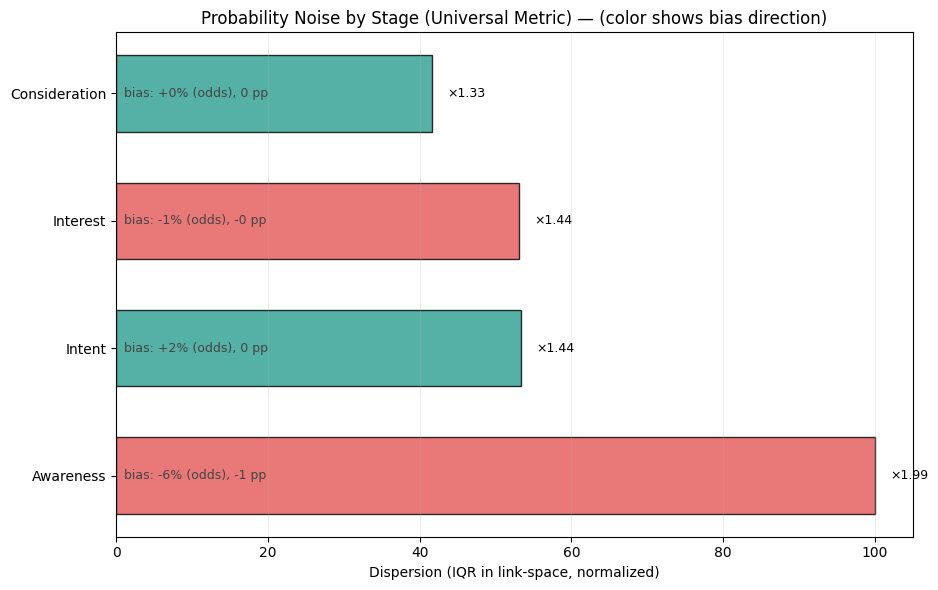

In [ ]:
# Build per-stage samples (probabilities)
prob_samples_by_stage = [win_probabilities_stage[:, j] for j in range(stage_probabilities.size)]
prob_bases = list(stage_probabilities)  # the listed stage probabilities

# Labels (use your funnel names)
try:
    stage_labels
except NameError:
    stage_labels = ["Awareness", "Interest", "Consideration", "Intent"]

universal_tornado(
    samples_by_item=prob_samples_by_stage,
    base_by_item=prob_bases,
    labels=stage_labels,
    kind='prob',
    title="Probability Noise by Stage (Universal Metric)"
)



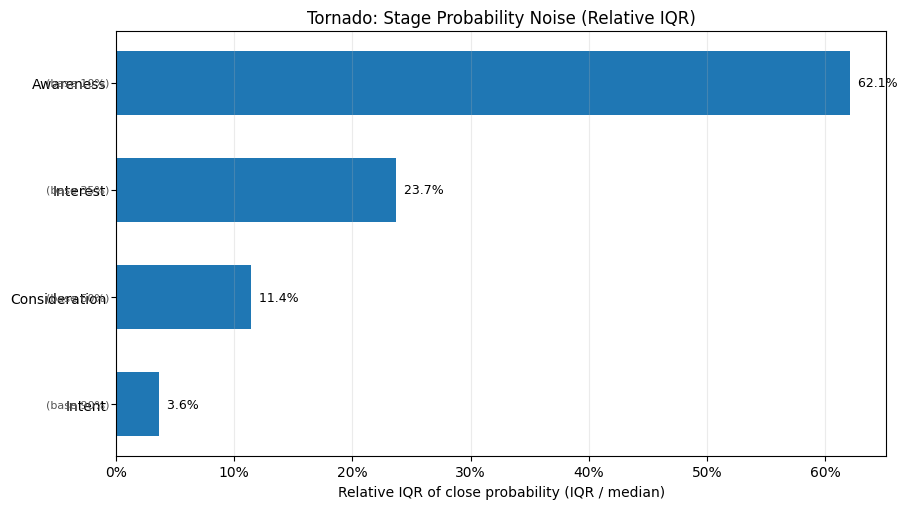

In [ ]:
# -------------------------------------------
# Tornado: Stage Probability Noise (Relative IQR)
# -------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Labels (use yours if already defined)
try:
    stage_labels
except NameError:
    stage_labels = [f"Stage {i+1}" for i in range(win_probabilities_stage.shape[1])]

# Quantiles across simulations, per stage
q25, q50, q75 = np.percentile(win_probabilities_stage, [25, 50, 75], axis=0)

# Relative IQR = (Q75 - Q25) / median  → as %
rel_iqr = (q75 - q25) / np.clip(q50, 1e-12, None) * 100.0

# Sort largest → smallest (tornado style)
order = np.argsort(rel_iqr)[::-1]
vals_sorted   = rel_iqr[order]
labels_sorted = [stage_labels[i] for i in order]
base_sorted   = (np.array(stage_probabilities) * 100.0)[order]  # for annotation

# Plot
fig, ax = plt.subplots(figsize=(9.2, 5.2))
y = np.arange(len(vals_sorted))
ax.barh(y, vals_sorted, height=0.6)  # default style; customize if you like
ax.invert_yaxis()                     # biggest on top

# Formatting
ax.set_yticks(y)
ax.set_yticklabels(labels_sorted)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.set_xlabel("Relative IQR of close probability (IQR / median)")
ax.set_title("Tornado: Stage Probability Noise (Relative IQR)")

# Annotations: bar value and base stage probability
for i, (v, base_pct) in enumerate(zip(vals_sorted, base_sorted)):
    ax.text(v, i, f"  {v:.1f}%", va="center", ha="left", fontsize=9)
    ax.text(0, i, f"(base {base_pct:.0f}%)  ", va="center", ha="right", fontsize=8, color="#555")

ax.grid(True, axis="x", alpha=0.25)
plt.tight_layout()
plt.show()


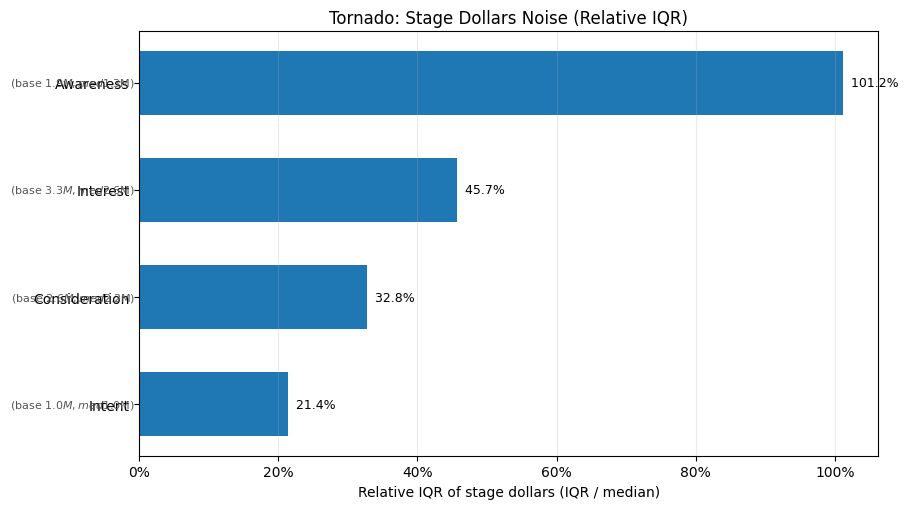

In [ ]:
# -------------------------------------------
# Tornado: Stage Dollars Noise (Relative IQR)
# -------------------------------------------
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter

# Labels (reuse yours if already defined)
try:
    stage_labels
except NameError:
    stage_labels = [f"Stage {i+1}" for i in range(len(stage_probabilities))]

# Per-deal stage index (D columns map to stage j)
stage_idx = np.repeat(np.arange(len(stage_probabilities)), stage_counts)

# Revenue per deal per simulation (N x D)
# (Ensure 'deal_values' broadcasts across rows)
revenue = win_binomial * deal_value_multipliers_output * deal_values[None, :]

# Aggregate per-stage revenue samples and a simple baseline per stage
rev_samples_by_stage = []
rev_base_by_stage    = []
for j in range(len(stage_probabilities)):
    cols = np.where(stage_idx == j)[0]
    s_j = revenue[:, cols].sum(axis=1)             # N samples for stage j
    rev_samples_by_stage.append(s_j)
    base_j = stage_probabilities[j] * deal_values[cols].sum()  # deterministic baseline
    rev_base_by_stage.append(base_j)

# Relative IQR per stage = (Q75 - Q25) / median  → %
rel_iqr = []
medians = []
for s_j in rev_samples_by_stage:
    q25, q50, q75 = np.percentile(s_j, [25, 50, 75])
    medians.append(q50)
    rel_iqr.append(((q75 - q25) / max(q50, 1e-12)) * 100.0)

rel_iqr   = np.array(rel_iqr)
medians   = np.array(medians)
base_dols = np.array(rev_base_by_stage)

# Sort largest → smallest (tornado style)
order         = np.argsort(rel_iqr)[::-1]
vals_sorted   = rel_iqr[order]
labels_sorted = [stage_labels[i] for i in order]
base_sorted   = base_dols[order]
med_sorted    = medians[order]

# Plot
fig, ax = plt.subplots(figsize=(9.2, 5.2))
y = np.arange(len(vals_sorted))
ax.barh(y, vals_sorted, height=0.6)
ax.invert_yaxis()  # biggest on top

# Formatting
ax.set_yticks(y)
ax.set_yticklabels(labels_sorted)
ax.xaxis.set_major_formatter(PercentFormatter(xmax=100))
ax.set_xlabel("Relative IQR of stage dollars (IQR / median)")
ax.set_title("Tornado: Stage Dollars Noise (Relative IQR)")

# Annotations: bar value + baseline/median in $ (millions)
def _fmt_m(v): return f"${v/1e6:.1f}M"
for i, (v, b, m) in enumerate(zip(vals_sorted, base_sorted, med_sorted)):
    ax.text(v, i, f"  {v:.1f}%", va="center", ha="left", fontsize=9)
    ax.text(0, i, f"(base {_fmt_m(b)}, med {_fmt_m(m)})  ",
            va="center", ha="right", fontsize=8, color="#555")

ax.grid(True, axis="x", alpha=0.25)
plt.tight_layout()
plt.show()
